In [1]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
import re
import gc
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fullmodel = T5ForConditionalGeneration.from_pretrained("models/prottrans_t5_xl_u50/").to(device)

fullmodel.full() if str(device)=='cpu' else fullmodel.half()

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('models/prottrans_t5_xl_u50', do_lower_case=False, legacy=False)


In [4]:
torch.cuda.empty_cache()

In [5]:
def sequence_masker(seq, i, j, same_extra_token=False):
    masked_sequence_list = seq.split()
    token_num = 0
    if j<=i:
        print(f"index j={j} must be greater than i={i}")
        raise
    for x in range(i, j):
        if j > len(seq):
            break
        masked_sequence_list[x] = f"<extra_id_{token_num}>"
        if not same_extra_token:
            token_num += 1
    return " ".join(masked_sequence_list)

test = "P R O T E I N A"


In [6]:
import random

testsequence = "PROTEINA"
testsequence = "CQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEED"
input_test = [" ".join(list(re.sub(r"[UZOB]", "X", testsequence)))]
print(input_test)

masked_test = [sequence_masker(input_test[0], 10, 11)]
print(masked_test)

ids1 = tokenizer.batch_encode_plus(input_test, add_special_tokens=True, padding="longest")
# print(ids1)
ids2 = tokenizer.batch_encode_plus(masked_test, add_special_tokens=True, padding="longest")
# print(ids2)

# print(tokenizer(input_test[0]))
# print(tokenizer(masked_test[0]))

['C Q K C D P S C P N G S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']
['C Q K C D P S C P N <extra_id_0> S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']


In [7]:
true_ids  = torch.tensor(ids1['input_ids']).to(device)
input_ids = torch.tensor(ids2['input_ids']).to(device)
attention_mask = torch.tensor(ids2['attention_mask']).to(device)

#embfull = fullmodel(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)

In [11]:
with torch.no_grad():
    loss = fullmodel(input_ids=input_ids, labels=true_ids).loss
    print(loss.item())

0.02410888671875


In [13]:
with torch.no_grad():
    emb = fullmodel(input_ids=input_ids, labels=true_ids)
    loss  = emb.loss.cpu()
    print(loss)

tensor(0.0241, dtype=torch.float16)


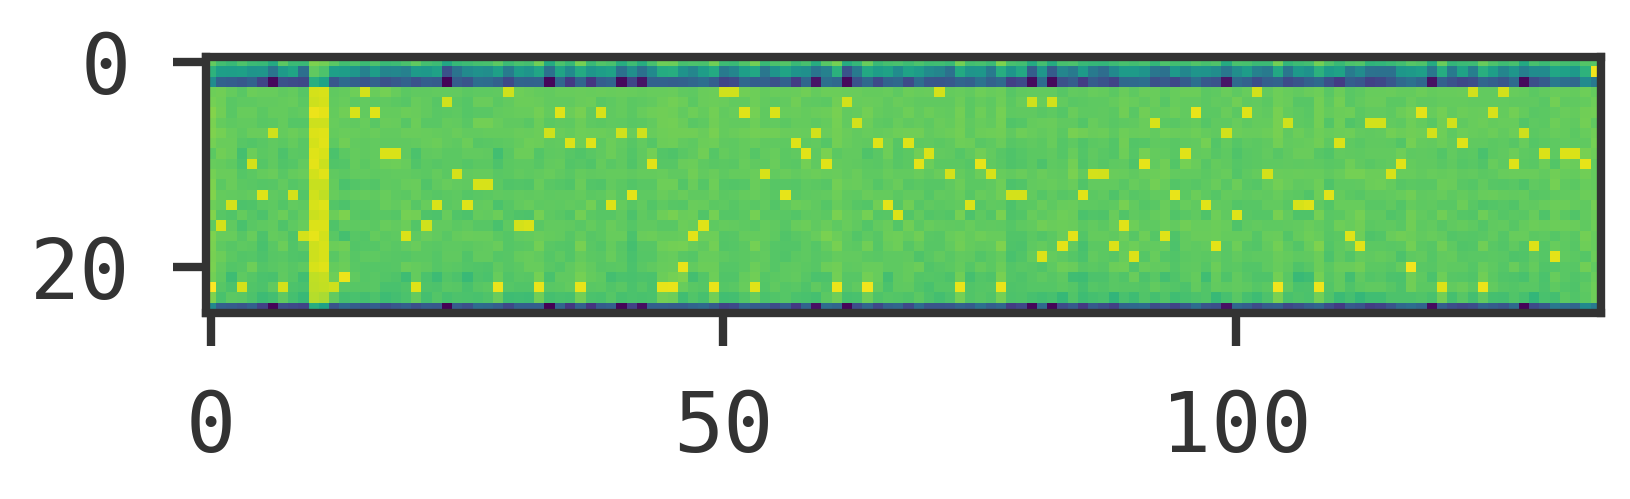

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# move tensor to cpu
logits_cpu = emb.logits[0,:,0:25].T.cpu()
ax.imshow(np.array(logits_cpu))
#ax.imshow(np.array(emb.logits[0,:,0:25].T))
plt.show()

In [15]:
print(masked_test)
print(input_ids)
with torch.no_grad():
    outputs = fullmodel.generate(input_ids=input_ids, max_length=200)
outputs
# tokenizer.get_vocab()

['C Q K C D P S C P N <extra_id_0> S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']
tensor([[ 22,  16,  14,  22,  10,  13,   7,  22,  13,  17, 127,   2,  22,  21,
           5,   3,   5,   9,   9,  17,  22,  16,  14,   4,  11,  14,  12,  12,
          22,   3,  16,  16,  22,   7,   5,   8,  22,   8,   5,  14,   7,  13,
           7,  10,  22,  22,  20,  17,  16,  22,   3,   3,   5,  22,  11,   5,
          13,   8,   9,   7,  10,  22,   4,   6,  22,   8,  14,  15,   8,  10,
           9,   3,  11,  22,  14,  10,  11,  22,  13,  13,   4,  19,   4,  18,
          17,  13,  11,  11,  18,  16,  19,  10,   6,  17,  13,   9,   5,  14,
          18,   7,  15,   5,   3,  11,  22,   6,  14,  14,  22,  13,   8,  17,
          18,   6,   6,  11,  10,  20,   5,   7,  22,   6,   8,   3,  22,   5,
    

tensor([[ 0, 22, 16, 14, 22, 10, 13,  7, 22, 13, 17,  5,  5, 22, 21,  5,  3,  5,
          9,  9, 17, 22, 16, 14,  4, 11, 14, 12, 12, 22,  3, 16, 16, 22,  7,  5,
          8, 22,  8,  5, 14,  7, 13,  7, 10, 22, 22, 20, 17, 16, 22,  3,  3,  5,
         22, 11,  5, 13,  8,  9,  7, 10, 22,  4,  6, 22,  8, 14, 15,  8, 10,  9,
          3, 11, 22, 14, 10, 11, 22, 13, 13,  4, 19,  4, 18, 17, 13, 11, 11, 18,
         16, 19, 10,  6, 17, 13,  9,  5, 14, 18,  7, 15,  5,  3, 11, 22,  6, 14,
         14, 22, 13,  8, 17, 18,  6,  6, 11, 10, 20,  5,  7, 22,  6,  8,  3, 22,
          5,  3, 10,  7, 18,  9, 19,  9,  9, 10,  1]], device='cuda:0')

In [16]:
tokenizer.decode(outputs[0])

'<pad> C Q K C D P S C P N G G C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D</s>'

In [17]:
tokenizer.decode(outputs[0], skip_special_tokens=True)

'C Q K C D P S C P N G G C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D'

In [18]:
input_test

['C Q K C D P S C P N G S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']

In [19]:
# Load one dataset

import json

disprot_file = "AF2_testset.json"
with open(disprot_file) as infmt:
    disprot_dict = json.load(infmt)

In [20]:
fullmodel.generation_config

GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.31.0"
}

In [98]:
from tqdm import tqdm

#torch.backends.cuda.enable_flash_sdp(True)

protids = list(disprot_dict.keys())
loss_dict = dict()
predmatch_dict = dict()
mask_sizes = [1, 5]
for test_prot in protids:
    print(test_prot)
    if test_prot not in predmatch_dict:
        predmatch_dict[test_prot] = dict()
    if test_prot not in loss_dict:
        loss_dict[test_prot] = dict()
    
    target_seq = disprot_dict[test_prot]['seq']
    input_seq = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]
    true_input = tokenizer(input_seq)
    true_tok = torch.tensor(true_input['input_ids']).to(device)

    for mask_size in mask_sizes:
        print(f"#### Mask size: {mask_size} ####")
               
        loss_sequence = list()
        match_sequence = list()
        for i in tqdm(range(len(target_seq)-mask_size+1)):

            masked_seq = [sequence_masker(input_seq[0], i, i+mask_size)]
            tmp = tokenizer(masked_seq)
            input_ids = torch.tensor(tmp['input_ids']).to(device)
            attention_mask = torch.tensor(tmp['attention_mask']).to(device)
            with torch.no_grad():
                emb  = fullmodel(input_ids=input_ids, labels=true_tok)
                loss = emb.loss.cpu()
                loss_sequence.append(loss.item())
                cpulogits = emb.logits.cpu()
                fastpred = tokenizer.decode(torch.tensor(cpulogits[:,:-1,:].numpy().argmax(-1)[0]), skip_special_tokens=False).replace("<"," <").replace(">","> ")
    #             outputs = fullmodel.generate(input_ids=input_ids, max_length=input_ids.shape[1]+10)
    #             prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    #             if fastpred == prediction:
    #                 print("OK ", end=" ")
                if input_seq[0] == fastpred:
                    match_sequence.append(True)
                else:
                    pred_arr = fastpred.split()
                    seq_arr  = input_seq[0].split()
                    if len(pred_arr) == len(seq_arr):
                        local_match_sequence = list()
                        for j in range(len(pred_arr)):
                            if pred_arr[j] != seq_arr[j]:
                                local_match_sequence.append((j,pred_arr[j], seq_arr[j]))
                    else:
                        print("Mismatch length error")
                        raise
                    match_sequence.append(local_match_sequence)
        predmatch_dict[test_prot][f"aa{mask_size}_match"] = match_sequence
        
        loss_dict[test_prot][f"aa{mask_size}_loss"] = loss_sequence
        torch.cuda.empty_cache()

P37840
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 140/140 [00:09<00:00, 15.54it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 136/136 [00:08<00:00, 16.05it/s]


P04637
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 393/393 [00:35<00:00, 11.20it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 389/389 [00:35<00:00, 11.10it/s]


P02686
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 304/304 [00:21<00:00, 14.23it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:20<00:00, 14.29it/s]


P07305
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 194/194 [00:12<00:00, 14.96it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.18it/s]


O00488
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 134/134 [00:08<00:00, 15.29it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 130/130 [00:08<00:00, 15.01it/s]


Q9NYB9
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 513/513 [01:11<00:00,  7.22it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 509/509 [01:10<00:00,  7.27it/s]


P06401
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 933/933 [05:52<00:00,  2.65it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 929/929 [05:52<00:00,  2.64it/s]


Q16186
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.01it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 403/403 [00:37<00:00, 10.87it/s]


S6B291
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 466/466 [00:52<00:00,  8.84it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 462/462 [00:52<00:00,  8.83it/s]


P23441
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 372/372 [00:29<00:00, 12.51it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 368/368 [00:29<00:00, 12.48it/s]


In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(np.array(cpulogits[0]))
plt.show()

In [100]:
with open("disprot_multi_loss.json", 'w') as outfmt:
    json.dump(loss_dict, outfmt)
with open("disprot_multi_mismatch.json", 'w') as outfmt:
    json.dump(predmatch_dict, outfmt)

In [ ]:

# fig = plt.figure(figsize=(6,6), dpi=100)
# ax = fig.add_subplot(111)
# ax.scatter(np.arange(len(target_seq)), loss_sequence)
# plt.show()

In [102]:
monomer_file = "monomer_datadict.json"
with open(monomer_file) as infmt:
    monomer_dict = json.load(infmt)

In [103]:
protids = list(monomer_dict.keys())
loss_dict = dict()
predmatch_dict = dict()
mask_sizes = [1, 5]
for test_prot in protids:
    print(test_prot)
    if test_prot not in predmatch_dict:
        predmatch_dict[test_prot] = dict()
    if test_prot not in loss_dict:
        loss_dict[test_prot] = dict()
    
    target_seq = monomer_dict[test_prot]['seq']
    input_seq = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]
    true_input = tokenizer(input_seq)
    true_tok = torch.tensor(true_input['input_ids']).to(device)

    for mask_size in mask_sizes:
        print(f"#### Mask size: {mask_size} ####")
               
        loss_sequence = list()
        match_sequence = list()
        for i in tqdm(range(len(target_seq)-mask_size+1)):

            masked_seq = [sequence_masker(input_seq[0], i, i+mask_size)]
            tmp = tokenizer(masked_seq)
            input_ids = torch.tensor(tmp['input_ids']).to(device)
            attention_mask = torch.tensor(tmp['attention_mask']).to(device)
            with torch.no_grad():
                emb  = fullmodel(input_ids=input_ids, labels=true_tok)
                loss = emb.loss.cpu()
                loss_sequence.append(loss.item())
                cpulogits = emb.logits.cpu()
                fastpred = tokenizer.decode(torch.tensor(cpulogits[:,:-1,:].numpy().argmax(-1)[0]), skip_special_tokens=False).replace("<"," <").replace(">","> ")
                if input_seq[0] == fastpred:
                    match_sequence.append(True)
                else:
                    pred_arr = fastpred.split()
                    seq_arr  = input_seq[0].split()
                    if len(pred_arr) == len(seq_arr):
                        local_match_sequence = list()
                        for j in range(len(pred_arr)):
                            if pred_arr[j] != seq_arr[j]:
                                local_match_sequence.append((j,pred_arr[j], seq_arr[j]))
                    else:
                        print("Mismatch length error")
                        raise
                    match_sequence.append(local_match_sequence)
        predmatch_dict[test_prot][f"aa{mask_size}_match"] = match_sequence
        
        loss_dict[test_prot][f"aa{mask_size}_loss"] = loss_sequence
        torch.cuda.empty_cache()


    
with open("monomer_multi_loss.json", 'w') as outfmt:
    json.dump(loss_dict, outfmt)
with open("monomer_multi_mismatch.json", 'w') as outfmt:
    json.dump(predmatch_dict, outfmt)

1AE9A
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 179/179 [00:11<00:00, 15.38it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 15.07it/s]


1AH7A
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 245/245 [00:16<00:00, 14.98it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 241/241 [00:16<00:00, 15.02it/s]


1AHOA
#### Mask size: 1 ####


100%|█████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 16.39it/s]


#### Mask size: 5 ####


100%|█████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.71it/s]


1AOCA
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 175/175 [00:11<00:00, 15.50it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 171/171 [00:10<00:00, 15.77it/s]


1AOLA
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 228/228 [00:14<00:00, 15.38it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 224/224 [00:14<00:00, 15.10it/s]


1AQZA
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 149/149 [00:09<00:00, 15.30it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 145/145 [00:09<00:00, 15.56it/s]


1ATGA
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:15<00:00, 15.38it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 227/227 [00:14<00:00, 15.44it/s]


1ATZA
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 189/189 [00:12<00:00, 15.72it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 185/185 [00:11<00:00, 15.55it/s]


1AYOB
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 130/130 [00:08<00:00, 15.58it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 126/126 [00:07<00:00, 15.94it/s]


1AZOA
#### Mask size: 1 ####


100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:15<00:00, 15.11it/s]


#### Mask size: 5 ####


100%|███████████████████████████████████████████████████████████████████████| 228/228 [00:15<00:00, 14.89it/s]


1B9WA
#### Mask size: 1 ####


100%|█████████████████████████████████████████████████████████████████████████| 95/95 [00:05<00:00, 15.91it/s]


#### Mask size: 5 ####


100%|█████████████████████████████████████████████████████████████████████████| 91/91 [00:05<00:00, 16.31it/s]
